# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [2]:
CIFAR_URL="https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"

In [3]:
import requests

def extract_cifar_data(url="https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # Todo: request the data from the data url (done)
    # Hint: use `requests.get` method
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [4]:
extract_cifar_data(CIFAR_URL)     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [5]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [6]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [7]:
# Feel free to explore the datasets
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [8]:
dataset_test.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [9]:
dataset_meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [10]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [11]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [12]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

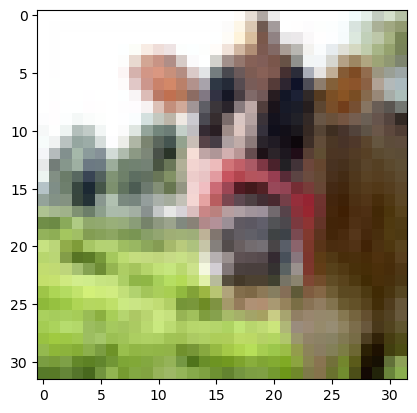

In [13]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [14]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [15]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [16]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [17]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [18]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [19]:
import pandas as pd

In [20]:
dataset_meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

In [21]:
# Retrieving labels name
df_meta = pd.DataFrame({
    "labels": dataset_meta[b"fine_label_names"],
})
df_meta.head()

,labels
0,b'apple'
1,b'aquarium_fish'
2,b'baby'
3,b'bear'
4,b'beaver'


In [22]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [23]:
# Decode df_meta.labels so they are regular strings
df_meta["labels"] = df_meta["labels"].apply(
    lambda x: x.decode("utf-8")
)

df_meta.head()

,labels
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver


In [24]:
### Todo: Filter the dataset_train and dataset_meta objects to find the 
# label numbers for Bicycle and Motorcycle

labels_df = df_meta[ (df_meta["labels"].str.lower()=="motorcycle") | 
                 (df_meta["labels"].str.lower()=="bicycle")  ]

labels_df

,labels
8,bicycle
48,motorcycle


In [25]:
labels_df.index

Int64Index([8, 48], dtype='int64')

In [26]:
# Get labels for vehicles of interest
labels_idx = labels_df.index.to_list()
labels_idx

[8, 48]

Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [27]:
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [28]:
# import json

In [29]:
#Construct the train dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames'])),
    
    # "batch_label": json.dumps(dataset_train[b"batch_label"]),
    # "coarse_labels": json.dumps(dataset_train[b"coarse_labels"]),
    # "flatten_pixels": json.dumps(dataset_train[b"data"]),
    
    # "batch_label": dataset_train[b"batch_label"],
    # "coarse_labels": dataset_train[b"coarse_labels"],
    "flatten_pixels": dataset_train[b"data"].tolist(),
    
})

df_train.head()

,filenames,labels,row,flatten_pixels
0,b'bos_taurus_s_000507.png',19,0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,b'stegosaurus_s_000125.png',29,1,"[255, 253, 253, 253, 253, 253, 253, 253, 253, ..."
2,b'mcintosh_s_000643.png',0,2,"[250, 248, 247, 248, 249, 249, 248, 248, 247, ..."
3,b'altar_boy_s_001435.png',11,3,"[124, 131, 135, 138, 140, 144, 148, 152, 156, ..."
4,b'cichlid_s_000031.png',1,4,"[43, 32, 87, 127, 55, 48, 51, 87, 121, 113, 13..."


In [30]:
df_train.shape

(50000, 4)

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   filenames       50000 non-null  object
 1   labels          50000 non-null  int64 
 2   row             50000 non-null  int64 
 3   flatten_pixels  50000 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [32]:
df_train["labels"].nunique()

100

In [33]:
# Keeping only relevant labels
df_train = df_train[ df_train["labels"].isin(labels_idx) ]
df_train["labels"].unique(), df_train.shape

(array([ 8, 48]), (1000, 4))

In [34]:
df_train["labels"].value_counts()

8     500
48    500
Name: labels, dtype: int64

In [35]:
df_train.sample(5,random_state=42)

,filenames,labels,row,flatten_pixels
25035,b'velocipede_s_001358.png',8,25035,"[84, 91, 98, 107, 112, 117, 121, 127, 133, 136..."
35368,b'bicycle_s_000039.png',8,35368,"[255, 252, 253, 253, 253, 253, 253, 253, 253, ..."
35589,b'motorcycle_s_002291.png',48,35589,"[185, 183, 184, 183, 182, 181, 182, 184, 182, ..."
32078,b'moped_s_000135.png',48,32078,"[61, 70, 44, 61, 117, 127, 122, 121, 142, 137,..."
19343,b'trail_bike_s_000016.png',48,19343,"[134, 132, 164, 207, 181, 227, 255, 255, 255, ..."


In [36]:
# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)

df_train.sample(5, random_state=42)

,filenames,labels,row,flatten_pixels
25035,velocipede_s_001358.png,8,25035,"[84, 91, 98, 107, 112, 117, 121, 127, 133, 136..."
35368,bicycle_s_000039.png,8,35368,"[255, 252, 253, 253, 253, 253, 253, 253, 253, ..."
35589,motorcycle_s_002291.png,48,35589,"[185, 183, 184, 183, 182, 181, 182, 184, 182, ..."
32078,moped_s_000135.png,48,32078,"[61, 70, 44, 61, 117, 127, 122, 121, 142, 137,..."
19343,trail_bike_s_000016.png,48,19343,"[134, 132, 164, 207, 181, 227, 255, 255, 255, ..."


In [37]:
# Create test df
df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames'])),
    
    "flatten_pixels": dataset_test[b"data"].tolist(),
})

df_test.head()

,filenames,labels,row,flatten_pixels
0,b'volcano_s_000012.png',49,0,"[199, 196, 195, 195, 196, 197, 198, 198, 199, ..."
1,b'woods_s_000412.png',33,1,"[113, 88, 72, 63, 72, 100, 131, 149, 139, 132,..."
2,b'seal_s_001803.png',72,2,"[61, 61, 67, 62, 64, 63, 70, 73, 78, 88, 85, 7..."
3,b'mushroom_s_001755.png',51,3,"[93, 88, 104, 90, 74, 70, 70, 75, 77, 60, 61, ..."
4,b'adriatic_sea_s_000653.png',71,4,"[80, 80, 82, 86, 92, 97, 96, 97, 98, 99, 100, ..."


In [38]:
df_test.shape

(10000, 4)

In [39]:
# Only keep relevant samples in df_test
df_test = df_test[ df_test["labels"].isin(labels_idx) ]
df_test["labels"].unique() ,df_test.shape

(array([ 8, 48]), (200, 4))

In [40]:
df_test.head()

,filenames,labels,row,flatten_pixels
27,b'safety_bike_s_000390.png',8,27,"[22, 34, 38, 33, 26, 9, 10, 9, 7, 19, 45, 57, ..."
28,b'bike_s_000658.png',8,28,"[216, 217, 215, 215, 214, 211, 208, 205, 201, ..."
116,b'velocipede_s_001744.png',8,116,"[255, 251, 251, 251, 251, 249, 240, 235, 237, ..."
161,b'bike_s_000643.png',8,161,"[74, 105, 118, 140, 166, 158, 163, 170, 165, 1..."
319,b'ordinary_bicycle_s_000437.png',8,319,"[195, 193, 193, 193, 193, 193, 193, 193, 193, ..."


In [41]:
df_test["labels"].value_counts()

8     100
48    100
Name: labels, dtype: int64

In [42]:
# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

df_test.head()

,filenames,labels,row,flatten_pixels
27,safety_bike_s_000390.png,8,27,"[22, 34, 38, 33, 26, 9, 10, 9, 7, 19, 45, 57, ..."
28,bike_s_000658.png,8,28,"[216, 217, 215, 215, 214, 211, 208, 205, 201, ..."
116,velocipede_s_001744.png,8,116,"[255, 251, 251, 251, 251, 249, 240, 235, 237, ..."
161,bike_s_000643.png,8,161,"[74, 105, 118, 140, 166, 158, 163, 170, 165, 1..."
319,ordinary_bicycle_s_000437.png,8,319,"[195, 193, 193, 193, 193, 193, 193, 193, 193, ..."


Looking at the images pixels structure

In [43]:
dataset_train[b'data'][0]

array([255, 255, 255, ...,  10,  59,  79], dtype=uint8)

In [44]:
type(dataset_train[b'data'])

numpy.ndarray

In [45]:
# #Construct the dataframe
# df_train = pd.DataFrame({
#     "filenames": dataset_train[b'filenames'],
#     "labels": dataset_train[b'fine_labels'],
#     "row": range(len(dataset_train[b'filenames']))
# })

# # Drop all rows from df_train where label is not 8 or 48
# df_train = #TODO: Fill in

# # Decode df_train.filenames so they are regular strings
# df_train["filenames"] = df_train["filenames"].apply(
#     lambda x: x.decode("utf-8")
# )


# df_test = pd.DataFrame({
#     "filenames": dataset_test[b'filenames'],
#     "labels": dataset_test[b'fine_labels'],
#     "row": range(len(dataset_test[b'filenames']))
# })

# # Drop all rows from df_test where label is not 8 or 48
# df_test = #TODO: Fill in

# # Decode df_test.filenames so they are regular strings
# df_test["filenames"] = df_test["filenames"].apply(
#     lambda x: x.decode("utf-8")
# )

Now that the data is filtered for just our classes, we can save all our images.

In [46]:
!mkdir ./train
!mkdir ./test

mkdir: cannot create directory ‘./train’: File exists
mkdir: cannot create directory ‘./test’: File exists


In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [47]:
# # Each 1024 in a row is a channel (red, green, then blue)
# row = dataset_train[b'data'][0]
# red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# # Each 32 items in the channel are a row in the 32x32 image
# red = red.reshape(32,32)
# green = green.reshape(32,32)
# blue = blue.reshape(32,32)

# # Combine the channels into a 32x32x3 image!
# combined = np.dstack((red,green,blue))

In [48]:
import random

In [49]:
def plot_random_image(df:pd.DataFrame):
    indexes = df.index.to_list()
    
    choosen_idx = random.choice(indexes)

    # Each 1024 in a row is a channel (red, green, then blue)
    flatten_pixels = np.array(df.loc[choosen_idx,"flatten_pixels"]) #dataset_train[b'data'][0]
    red, green, blue = flatten_pixels[0:1024], flatten_pixels[1024:2048], flatten_pixels[2048:]

    # Each 32 items in the channel are a row in the 32x32 image
    red = red.reshape(32,32)
    green = green.reshape(32,32)
    blue = blue.reshape(32,32)

    # Combine the channels into a 32x32x3 image!
    image = np.dstack((red,green,blue))

    plt.title(df.loc[choosen_idx,"filenames"])
    plt.imshow(image);

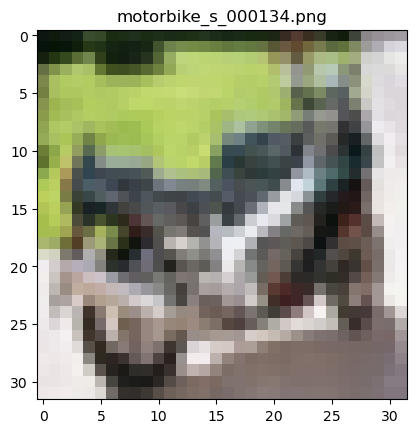

In [50]:
plot_random_image(df_train)

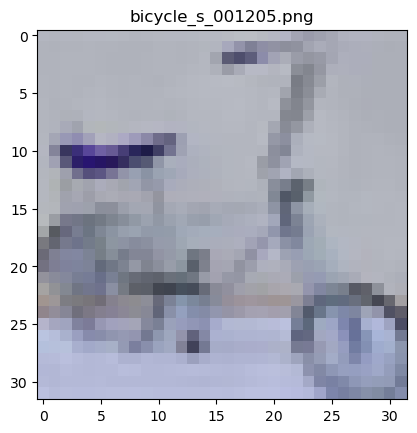

In [51]:
plot_random_image(df_train)

In [52]:
import os

In [53]:
# def save_images(df:pd.DataFrame, images:np.ndarray, save_path:str):
#     for index, row in df.iterrows():
        
#         # The code may take time, log in the console to keep track of things
#         if index==0 or index%100==0:
#             print(f"Currently processing sample {index} over {df.shape[0]} (note: indexes not reset)...")
        
#         # Each 1024 in a row is a channel (red, green, then blue)
#         flatten_pixels = images[index] #df.loc[index, b"flatten_pixels"]
#         red_channel, green_channel, blue_channel = flatten_pixels[0:1024], flatten_pixels[1024:2048], flatten_pixels[2048:]
    
#         # Each 32 items in the channel are a row in the 32x32 image
#         red_channel = red_channel.reshape(32,32)
#         green_channel = red_channel.reshape(32,32)
#         blue_channel = red_channel.reshape(32,32)
        
#         # Combine the channels into a 32x32x3 image!
#         image = np.dstack((red,green,blue))
        
#         image_path = os.path.join(save_path, df.loc[index, 'filenames'] )
        
#         # plt.imshow(image)
        
#         plt.imsave(image_path, image)
    
#     print(f"All images processed in {save_path}")
    
# #     #Grab the image data in row-major form
# #     img = 
    
# #     # Consolidated stacking/reshaping from earlier
# #     target = 
    
# #     # Save the image
    
    
#     # Return any signal data you want for debugging (done)
#     return True

In [54]:
def save_images(df:pd.DataFrame, save_path:str):
    for index, row in df.iterrows():
        
        # The code may take time, log in the console to keep track of things
        if index==0 or index%100==0:
            print(f"Currently processing sample {index} over {df.shape[0]} (note: indexes not reset)...")
        
        # Each 1024 in a row is a channel (red, green, then blue)
        flatten_pixels = np.array(df.loc[index,"flatten_pixels"]).astype(np.uint8) #df.loc[index, b"flatten_pixels"]
        red_channel, green_channel, blue_channel = flatten_pixels[0:1024], flatten_pixels[1024:2048], flatten_pixels[2048:]
    
        # Each 32 items in the channel are a row in the 32x32 image
        red_channel = red_channel.reshape(32,32)
        green_channel = green_channel.reshape(32,32)
        blue_channel = blue_channel.reshape(32,32)
        
        # Combine the channels into a 32x32x3 image!
        image = np.dstack((red_channel,green_channel,blue_channel))
        
        image_path = os.path.join(save_path, df.loc[index, 'filenames'] )
        
        plt.imsave(image_path, image)
    
    print(f"All images processed in {save_path}")
    
#     #Grab the image data in row-major form
#     img = 
    
#     # Consolidated stacking/reshaping from earlier
#     target = 
    
#     # Save the image
    
    
    # Return any signal data you want for debugging (done)
    return True

In [55]:
df_train.shape, df_test.shape

((1000, 4), (200, 4))

In [56]:
df_train.sample(5, random_state=42)

,filenames,labels,row,flatten_pixels
25035,velocipede_s_001358.png,8,25035,"[84, 91, 98, 107, 112, 117, 121, 127, 133, 136..."
35368,bicycle_s_000039.png,8,35368,"[255, 252, 253, 253, 253, 253, 253, 253, 253, ..."
35589,motorcycle_s_002291.png,48,35589,"[185, 183, 184, 183, 182, 181, 182, 184, 182, ..."
32078,moped_s_000135.png,48,32078,"[61, 70, 44, 61, 117, 127, 122, 121, 142, 137,..."
19343,trail_bike_s_000016.png,48,19343,"[134, 132, 164, 207, 181, 227, 255, 255, 255, ..."


In [57]:
df_test.sample(5, random_state=42)

,filenames,labels,row,flatten_pixels
5162,motorcycle_s_000685.png,48,5162,"[166, 167, 171, 174, 176, 178, 180, 181, 182, ..."
790,motorcycle_s_000963.png,48,790,"[253, 250, 250, 250, 250, 250, 250, 250, 250, ..."
1469,velocipede_s_000292.png,8,1469,"[184, 186, 190, 193, 196, 197, 199, 200, 200, ..."
7806,minibike_s_000254.png,48,7806,"[209, 205, 205, 206, 207, 207, 207, 206, 205, ..."
6553,velocipede_s_001633.png,8,6553,"[159, 168, 180, 192, 203, 212, 219, 224, 228, ..."


In [58]:
# save train image to disk
save_images(df_train, "./train") #save_images(df_train, dataset_train[b"data"], "./train")

Currently processing sample 4600 over 1000 (note: indexes not reset)...
Currently processing sample 4900 over 1000 (note: indexes not reset)...
Currently processing sample 10000 over 1000 (note: indexes not reset)...
Currently processing sample 15600 over 1000 (note: indexes not reset)...
Currently processing sample 16800 over 1000 (note: indexes not reset)...
Currently processing sample 28500 over 1000 (note: indexes not reset)...
Currently processing sample 31900 over 1000 (note: indexes not reset)...
Currently processing sample 34500 over 1000 (note: indexes not reset)...
Currently processing sample 36200 over 1000 (note: indexes not reset)...
Currently processing sample 41800 over 1000 (note: indexes not reset)...
Currently processing sample 44000 over 1000 (note: indexes not reset)...
Currently processing sample 44300 over 1000 (note: indexes not reset)...
All images processed in ./train


True

In [59]:
# save train image to disk
save_images(df_test, "./test")  # save_images(df_test, dataset_test[b"data"], "./test")

Currently processing sample 8300 over 200 (note: indexes not reset)...
All images processed in ./test


True

In [60]:
import matplotlib.image as mpimg

In [61]:
def plot_random_image_in_folder(folder:str):
    
    # Get one random image path
    random_image = random.sample(os.listdir(folder), 1)
    
    # Read image
    image = mpimg.imread(os.path.join(folder, random_image[0]))
    plt.imshow(image)
    plt.title(random_image)
    plt.axis("off");
    

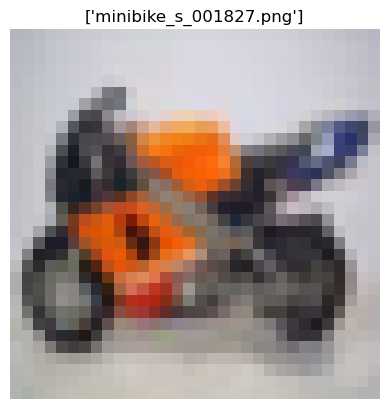

In [62]:
plot_random_image_in_folder("./train")

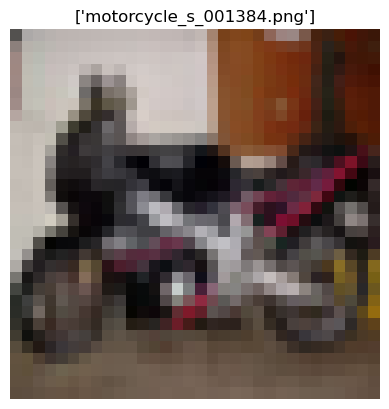

In [63]:
plot_random_image_in_folder("./train")

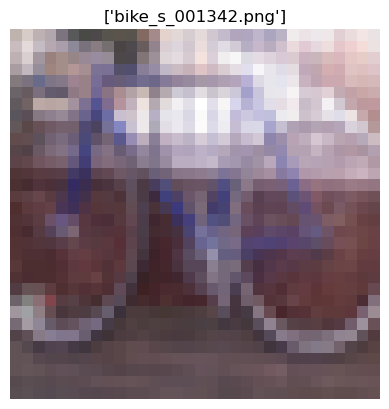

In [64]:
plot_random_image_in_folder("./test")

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [65]:
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()
session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [66]:
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

Default Bucket: sagemaker-us-west-2-659095202386


In [67]:
region = session.boto_region_name
print("AWS Region: {}".format(region))

AWS Region: us-west-2


In [68]:
role = get_execution_role()
print("RoleArn: {}".format(role))

RoleArn: arn:aws:iam::659095202386:role/service-role/AmazonSageMaker-ExecutionRole-20230822T154211


With this data we can easily sync your data up into S3!

In [69]:
prefix = "udacity-project-4"
prefix

'udacity-project-4'

In [70]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
os.environ["PREFIX"] = prefix

!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/${PREFIX}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/${PREFIX}/test/

print("Data sync up into s3")

upload: train/bicycle_s_000021.png to s3://sagemaker-us-west-2-659095202386/udacity-project-4/train/bicycle_s_000021.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-west-2-659095202386/udacity-project-4/train/bicycle_s_000038.png
upload: train/bicycle_s_000017.png to s3://sagemaker-us-west-2-659095202386/udacity-project-4/train/bicycle_s_000017.png
upload: train/bicycle_s_000071.png to s3://sagemaker-us-west-2-659095202386/udacity-project-4/train/bicycle_s_000071.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-west-2-659095202386/udacity-project-4/train/bicycle_s_000035.png
upload: train/bicycle_s_000124.png to s3://sagemaker-us-west-2-659095202386/udacity-project-4/train/bicycle_s_000124.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-west-2-659095202386/udacity-project-4/train/bicycle_s_000039.png
upload: train/bicycle_s_000149.png to s3://sagemaker-us-west-2-659095202386/udacity-project-4/train/bicycle_s_000149.png
upload: train/bicycle_s_000043.p

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [71]:
labels_df

,labels
8,bicycle
48,motorcycle


In [72]:
df_train.head()

,filenames,labels,row,flatten_pixels
16,bike_s_000682.png,8,16,"[35, 27, 31, 77, 136, 168, 103, 101, 85, 63, 6..."
30,bike_s_000127.png,8,30,"[88, 104, 112, 81, 40, 39, 41, 47, 87, 119, 16..."
130,cycle_s_002598.png,8,130,"[89, 88, 89, 88, 89, 90, 90, 90, 90, 90, 90, 9..."
152,minibike_s_000824.png,48,152,"[158, 160, 163, 168, 173, 177, 178, 180, 181, ..."
195,motorcycle_s_001856.png,48,195,"[255, 255, 255, 255, 255, 255, 248, 220, 201, ..."


In [73]:
def to_metadata_file(df:pd.DataFrame, prefix:str):
    """
        Save dataframe on disk, after :
            - adding each file path on s3 in a new column
            - updating the label to reflect the project goal: 0 (instead of 8, for bicycle), 1 (instead of 48, for motorcycle)
    """
    
    # adding a new column for image path on s3 
    df["s3_path"] = df["filenames"]
    
    # replacing current label (8 and 48, for bicycle and motorcycle) by new ones (0 and 1, for binary classification)
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1) #8: label for bicycle
    
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )


In [74]:
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

print("Done")

Done


In [75]:
!ls -lrta

total 166084
-rw-r--r-- 1 root root     36954 Aug 23 12:44  starter.ipynb
drwxr-xr-x 9 root root      6144 Aug 23 12:44  ..
drwx------ 2 root root      6144 Aug 28 15:42  cifar-100-python
drwxr-xr-x 2 root root      6144 Sep  5 15:30  captured_data
-rw-r--r-- 1 root root    398306 Sep  5 16:10 'project 4.ipynb'
drwxr-xr-x 2 root root      6144 Sep  6 09:26  .ipynb_checkpoints
drwxr-xr-x 2 root root     43008 Sep  7 10:35  train
drwxr-xr-x 2 root root     14336 Sep  7 10:35  test
-rw-r--r-- 1 root root    501695 Sep  7 12:04 'project 4-v2.ipynb'
drwxr-xr-x 7 root root      6144 Sep  7 12:04  .
-rw-r--r-- 1 root root 169001437 Sep  7 12:04  cifar.tar.gz
-rw-r--r-- 1 root root      2901 Sep  7 12:04  file.png
-rw-r--r-- 1 root root     30604 Sep  7 12:05  train.lst
-rw-r--r-- 1 root root      5920 Sep  7 12:05  test.lst


We can also upload our manifest files:

In [76]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(bucket).Object(f"{prefix}/train.lst").upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(bucket).Object(f"{prefix}/test.lst").upload_file('./test.lst')

print("Done")

Done


Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [77]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve("image-classification", region, "latest")
algo_image

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


'433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:1'

In [78]:
s3_output_location = f"s3://{bucket}/{prefix}/models/image_model"
s3_output_location

's3://sagemaker-us-west-2-659095202386/udacity-project-4/models/image_model'

We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [79]:
img_classifier_model=sagemaker.estimator.Estimator(
    algo_image,
    role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    output_path=s3_output_location,
    sagemaker_session=session
)

img_classifier_model

We can also set a few key hyperparameters and define the inputs for our model:

In [80]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

img_classifier_model.set_hyperparameters(
    image_shape= '3,32,32' , # The input image dimensions, which is the same size as the input layer of the network. The format is defined as 'num_channels, height, width'
    num_classes= 2, 
    num_training_samples= df_train.shape[0],
    
    # augmentation_type="crop_color_transform",
    # use_pretrained_model=1,
    # early_stopping=True,
    # top_k=5
)

type(img_classifier_model)

sagemaker.estimator.Estimator

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [81]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/{prefix}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/{prefix}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/{prefix}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/{prefix}/test.lst",
            content_type="application/x-image"
        )
}

model_inputs

{'train': <sagemaker.inputs.TrainingInput at 0x7f3767097b20>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f3767094400>,
 'train_lst': <sagemaker.inputs.TrainingInput at 0x7f37670959f0>,
 'validation_lst': <sagemaker.inputs.TrainingInput at 0x7f3767096560>}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [82]:
img_classifier_model.fit(model_inputs)

INFO:sagemaker:Creating training-job with name: image-classification-2023-09-07-12-05-50-906


2023-09-07 12:05:51 Starting - Starting the training job......
2023-09-07 12:06:25 Starting - Preparing the instances for training......
2023-09-07 12:07:29 Downloading - Downloading input data...
2023-09-07 12:07:54 Training - Downloading the training image............
2023-09-07 12:09:55 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Thu Sep  7 12:10:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Us

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.


### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [83]:
data_capture_url = f"s3://{bucket}/{prefix}/data_capture"
data_capture_url

's3://sagemaker-us-west-2-659095202386/udacity-project-4/data_capture'

In [84]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    destination_s3_uri= data_capture_url, #f"s3://{bucket}/{prefix}/data_capture",
    enable_capture=True,
    sampling_percentage=70
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [85]:
deployment = img_classifier_model.deploy(
    data_capture_config=data_capture_config,
    initial_instance_count=1,
    instance_type="ml.m5.xlarge"
)

deployment

INFO:sagemaker:Creating model with name: image-classification-2023-09-07-12-14-33-954
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-09-07-12-14-33-954
INFO:sagemaker:Creating endpoint with name image-classification-2023-09-07-12-14-33-954


-----------!

In [86]:
endpoint = deployment.endpoint_name
endpoint

'image-classification-2023-09-07-12-14-33-954'

Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [87]:
# reference: https://github.com/aws/sagemaker-python-sdk/issues/166
from sagemaker.predictor import RealTimePredictor

predictor = RealTimePredictor(endpoint)
predictor

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f376785e6e0>

*Though sagemaker.predictor.RealTimePredictor is deprecated and has been renamed in sagemaker>=2 (kindly refer to [doc]( https://sagemaker.readthedocs.io/en/stable/v2.html), I am still using it instead of using sagemaker.predictor.Predictor in order to conform to this project specs.*

In [88]:
# # https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor
# from sagemaker.predictor import Predictor

# predictor = Predictor(endpoint)
# predictor

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [89]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)
inference

b'[0.9811985492706299, 0.018801426514983177]'

In [90]:
inference.decode("utf-8")

'[0.9811985492706299, 0.018801426514983177]'

In [91]:
eval(inference.decode("utf-8"))

[0.9811985492706299, 0.018801426514983177]

Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

### Draft Lambdas and Step Function Workflow

Your operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage you're going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that you can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with your bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, your functions can read and write the necessary data to execute your workflow. Let's start with the first function. Your first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

Go to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select thr 'Python 3.8' runtime. Add the same permissions as the SageMaker role you created earlier. (Reminder: you do this in the Configuration tab under "Permissions"). Once you're ready, use the starter code below to craft your Lambda handler:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = ## TODO: fill in
    bucket = ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) you'll need to package them in your function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency

Create a new Lambda function with the same rights and a descriptive name, then fill in the starter code below for your classifier Lambda.

```python
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(## TODO: fill in)

    # Instantiate a Predictor
    predictor = ## TODO: fill in

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = ## TODO: fill in
    
    # We return the data back to the Step Function    
    event["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```

Finally, we need to filter low-confidence inferences. Define a threshold between 1.00 and 0.000 for your model: what is reasonble for you? If the model predicts at `.70` for it's highest confidence label, do we want to pass that inference along to downstream systems? Make one last Lambda function and tee up the same permissions:

```python
import json


THRESHOLD = .93


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    inferences = ## TODO: fill in
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = ## TODO: fill in
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```
Once you have tested the lambda functions, save the code for each lambda function in a python script called 'lambda.py'.

With your lambdas in place, you can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console you'll have the option to author a Standard step function *Visually*.

When the visual editor opens, you'll have many options to add transitions in your workflow. We're going to keep it simple and have just one: to invoke Lambda functions. Add three of them chained together. For each one, you'll be able to select the Lambda functions you just created in the proper order, filter inputs and outputs, and give them descriptive names.

Make sure that you:

1. Are properly filtering the inputs and outputs of your invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for your operations colleagues!

Take a screenshot of your working step function in action and export the step function as JSON for your submission package.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [92]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    # https://techoverflow.net/2021/03/08/how-to-filter-for-objects-in-a-given-s3-directory-using-boto3/
    objects = s3.Bucket(bucket).objects.filter(Prefix=f"{prefix}/test/")
    # print(objects)
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj,
        
        "prefix":prefix
    })

def generate_test_case_():
    s3 = boto3.client("s3")
    response = s3.list_objects_v2(
            Bucket=bucket,
            Prefix =f"{prefix}/test",
            MaxKeys=100)
    
    print(response["Contents"])

generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-west-2-659095202386", "s3_key": "udacity-project-4/test/safety_bike_s_000438.png", "prefix": "udacity-project-4"}'

In [93]:
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-west-2-659095202386", "s3_key": "udacity-project-4/test/cycle_s_001648.png", "prefix": "udacity-project-4"}'

In [115]:
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-west-2-659095202386", "s3_key": "udacity-project-4/test/safety_bike_s_001690.png", "prefix": "udacity-project-4"}'

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [116]:
# data_capture_url

In [117]:
# from sagemaker.s3 import S3Downloader

# # In S3 your data will be saved to a datetime-aware path
# # Find a path related to a datetime you're interested in
# data_path = ""

# S3Downloader.download(data_path, "captured_data")

# # Feel free to repeat this multiple times and pull in more data

In [ ]:
# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
# Feel free to repeat this multiple times and pull in more data

In [122]:
from sagemaker.s3 import S3Downloader
import boto3

def download_capture_files(bucket:str,capture_folder:str):
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    # https://techoverflow.net/2021/03/08/how-to-filter-for-objects-in-a-given-s3-directory-using-boto3/
    objects = s3.Bucket(bucket).objects.filter(Prefix=capture_folder)
    # print(objects)
    
    # Get files names
    files = [x.key for x in objects]
    
    for file in files:
        data_path = f"s3://{os.path.join(bucket, file)}"
        print(f"Processing file {data_path} ...")
        S3Downloader.download(data_path, "captured_data")
    
    print("Done")


In [123]:
capture_folders=[
    "udacity-project-4/data_capture/image-classification-2023-09-07-12-14-33-954/AllTraffic/2023/09/07/12/",
    "udacity-project-4/data_capture/image-classification-2023-09-07-12-14-33-954/AllTraffic/2023/09/07/13/",
    "udacity-project-4/data_capture/image-classification-2023-09-07-12-14-33-954/AllTraffic/2023/09/07/14/",
]

for folder in capture_folders:
    download_capture_files(bucket, folder)

Processing file s3://sagemaker-us-west-2-659095202386/udacity-project-4/data_capture/image-classification-2023-09-07-12-14-33-954/AllTraffic/2023/09/07/12/28-55-057-8df3f4da-10c7-4630-bd9a-06a194bc3d9d.jsonl ...
Processing file s3://sagemaker-us-west-2-659095202386/udacity-project-4/data_capture/image-classification-2023-09-07-12-14-33-954/AllTraffic/2023/09/07/12/40-51-274-4393e003-c3f9-4075-bdf9-363ea6946cde.jsonl ...
Done
Processing file s3://sagemaker-us-west-2-659095202386/udacity-project-4/data_capture/image-classification-2023-09-07-12-14-33-954/AllTraffic/2023/09/07/13/10-45-594-227a6f78-67a9-4979-87ed-4ecdf70f06f6.jsonl ...
Processing file s3://sagemaker-us-west-2-659095202386/udacity-project-4/data_capture/image-classification-2023-09-07-12-14-33-954/AllTraffic/2023/09/07/13/30-51-071-f3e162c9-0020-4dc1-8f39-8bd69ef0f838.jsonl ...
Processing file s3://sagemaker-us-west-2-659095202386/udacity-project-4/data_capture/image-classification-2023-09-07-12-14-33-954/AllTraffic/2023/0

In [124]:
# data_path = "s3://sagemaker-us-west-2-659095202386/udacity-project-4/data_capture/image-classification-2023-09-05-10-24-54-478/AllTraffic/2023/09/05/14/25-08-500-d6392e73-0915-4e27-bf51-8b7e1f95cab1.jsonl"

# S3Downloader.download(data_path, "captured_data")

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [125]:
!pip install jsonlines
import jsonlines

  Obtaining dependency information for jsonlines from https://files.pythonhosted.org/packages/f8/62/d9ba6323b9202dd2fe166beab8a86d29465c41a0288cbe229fac60c1ab8d/jsonlines-4.0.0-py3-none-any.whl.metadata
  Using cached jsonlines-4.0.0-py3-none-any.whl.metadata (1.6 kB)
Using cached jsonlines-4.0.0-py3-none-any.whl (8.7 kB)


Now we can extract the data from each of the source files:

In [131]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    print(f"jsonl: {jsonl}")
    #if os.path.isfile(jsonl):
    if jsonl != ".ipynb_checkpoints": # a fix to avoid the notebook checkpoint being used (not enough time to restart the work and avoid this file being present)
        with jsonlines.open(f"./captured_data/{jsonl}") as f:
            json_data.append(f.read())

jsonl: 30-51-071-f3e162c9-0020-4dc1-8f39-8bd69ef0f838.jsonl
jsonl: 40-51-274-4393e003-c3f9-4075-bdf9-363ea6946cde.jsonl
jsonl: 54-12-854-d890778d-8323-43c0-a2c5-398b858e6aba.jsonl
jsonl: 01-40-609-6dd40f52-1036-4ac2-8b91-219e9d89ce7b.jsonl
jsonl: .ipynb_checkpoints
jsonl: 40-54-217-c6202f75-dd1e-4462-a7e7-493c26ef0ec1.jsonl
jsonl: 00-25-148-d28f14d6-1cd3-40bb-94f0-7a3c10003718.jsonl
jsonl: 28-55-057-8df3f4da-10c7-4630-bd9a-06a194bc3d9d.jsonl
jsonl: 03-57-607-1f07d5f2-5492-449a-9bdc-79441e08be13.jsonl
jsonl: 10-45-594-227a6f78-67a9-4979-87ed-4ecdf70f06f6.jsonl
jsonl: 48-49-505-314b45a2-629e-4000-af03-35ef9c3aed30.jsonl


In [136]:
!ls -lart ./captured_data

total 88
drwxr-xr-x 2 root root 6144 Sep  7 13:18 .ipynb_checkpoints
-rw-r--r-- 1 root root 3648 Sep  7 14:10 28-55-057-8df3f4da-10c7-4630-bd9a-06a194bc3d9d.jsonl
-rw-r--r-- 1 root root 4330 Sep  7 14:10 40-51-274-4393e003-c3f9-4075-bdf9-363ea6946cde.jsonl
-rw-r--r-- 1 root root 4013 Sep  7 14:10 10-45-594-227a6f78-67a9-4979-87ed-4ecdf70f06f6.jsonl
-rw-r--r-- 1 root root 4267 Sep  7 14:10 30-51-071-f3e162c9-0020-4dc1-8f39-8bd69ef0f838.jsonl
-rw-r--r-- 1 root root 3284 Sep  7 14:10 40-54-217-c6202f75-dd1e-4462-a7e7-493c26ef0ec1.jsonl
-rw-r--r-- 1 root root 4166 Sep  7 14:10 48-49-505-314b45a2-629e-4000-af03-35ef9c3aed30.jsonl
-rw-r--r-- 1 root root 4502 Sep  7 14:10 54-12-854-d890778d-8323-43c0-a2c5-398b858e6aba.jsonl
-rw-r--r-- 1 root root 4618 Sep  7 14:10 00-25-148-d28f14d6-1cd3-40bb-94f0-7a3c10003718.jsonl
-rw-r--r-- 1 root root 8561 Sep  7 14:10 01-40-609-6dd40f52-1036-4ac2-8b91-219e9d89ce7b.jsonl
-rw-r--r-- 1 root root 8486 Sep  7 14:10 03-57-607-1f07d5f2-5492-449a-9bdc-79441e08be

In [137]:
json_data[0]

{'captureData': {'endpointInput': {'observedContentType': 'image/png',
   'mode': 'INPUT',
   'data': 'iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAKyUlEQVR4nD2X6Y9l1XXFf+fcc+7w5pqnHqDapg2IOAwBFGPZsRTFUT5Yshz/i/mYSImiRFYSYWEbMCJgoBuoaqqruqbX7716w33vTmfKh7Kyv2/tddbaZ2lt8dN/fCcUdcV8mSMjzfraOr6xREisgavza3wTcMahYsULLx0Sr7cp6pKWUhACVVUjAwzSHgJNT/dIpObL00esTE61qknjNlVTo4WksYbgA76qUaa0VLMauwyE4FjmK2xZ0klT0iTlcPOAyXzOPM9ZG6xxsLeN6kq8bBGagECQZhntJKGlYmY3NevZPpPLEZlWpK0eK1HgrEAmMaZusN4iI4nOEtT58SXLRUE767DR7ZN4yJuS/maPe/fusba1wWw1Z7FaIqVic9BmY7fP+vYaSaeLihRSSlQkCU1DVUrMPEIFT0heZOfeFqaylIuKfJUzvblhOJ9S2BpbN6jMZzTKolJFeydjfafPvcEB2/tb7O/fZ219jbilMKZB+4RIKZIsJdIR3huEAO8DgkBIAiQSZxs2D7pkvbu011oE42myhmDWKbd3uJpNGBc5q7pEHb77PdprKZ1Bl42dDdZ3emRbGb00JYgMJyUgiOsIrRQqSXFovJRI7zG2RoqI4EBKj3UNqq8Rukt7u01TVUgXEN5RL2rSWLHd7dFqtxitlqi3/uEN4pZCRzFxkiBkwCmFaQRK1QQBQSqSWBFLiRSe4Cuc89SuxAePQKFUj

The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [138]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.0077815307304263115, 0.9922184944152832], '2023-09-07T13:30:51Z')

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


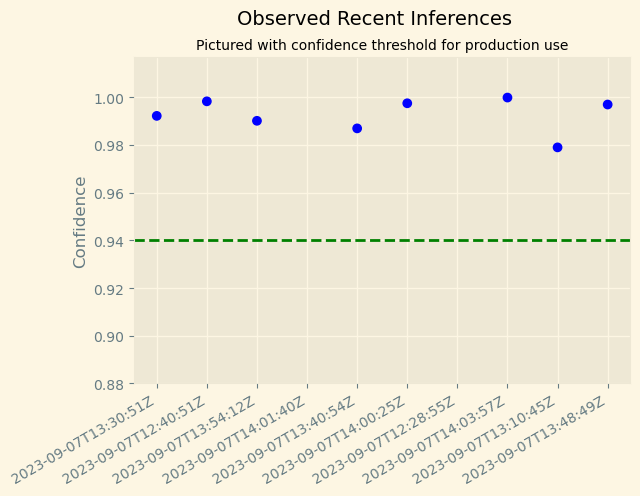

In [139]:
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

### Todo: build your own visualization


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


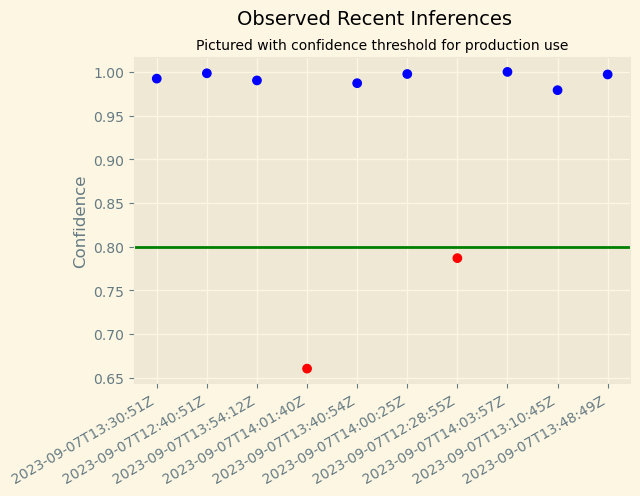

In [140]:
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

THRESHOLD = .8 #.93

# Plot the data
plt.scatter(x, y, c=['r' if k<THRESHOLD else 'b' for k in y ])
plt.axhline(y=THRESHOLD, color='g')
# plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)


plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

### Congratulations!

You've reached the end of the project. In this project you created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. You used the SageMaker Estimator API to deploy your SageMaker Model and Endpoint, and you used AWS Lambda and Step Functions to orchestrate your ML workflow. Using SageMaker Model Monitor, you instrumented and observed your Endpoint, and at the end of the project you built a visualization to help stakeholders understand the performance of the Endpoint over time. If you're up for it, you can even go further with these stretch goals:

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.
* Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?
* Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?
* What if we want to get notified every time our step function errors out? Can we use the Step Functions visual editor in conjunction with a service like SNS to accomplish this? Try it out!


